## Selección del Modelo

### Importamos librerías

In [ ]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from joblib import dump, load
from scipy.stats import f_oneway
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    HalvingGridSearchCV,
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

### Data Load

In [2]:
DATA_DIR = Path.cwd() / "data"

melbourne_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/melbourne_type_fixed.parquet", engine="pyarrow"
)

### Selección de variables que salieron del Feature Engineering

In [3]:
# Definir las columnas numéricas y categóricas
num_cols = ["Rooms", "Bedroom2", "Bathroom", "YearBuilt", "BuildingArea"]
selected_cat_cols = ["Type", "Regionname", "CouncilArea", "Method"]

In [ ]:
def remove_outliers_iqr(df, numeric_cols):
    df_filtered = df.copy()
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[
            (df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)
        ]
    return df_filtered


melbourne_df = remove_outliers_iqr(melbourne_df, num_cols)

In [5]:
# Imputación de valores faltantes antes del preprocesamiento
imputer = SimpleImputer(strategy="mean")
melbourne_df[num_cols] = imputer.fit_transform(melbourne_df[num_cols])

In [6]:
# Separar las características (X) y la variable objetivo (y)
X_features = melbourne_df[num_cols + selected_cat_cols]
Y_target = melbourne_df["Price"]

In [7]:
# Eliminar valores atípicos en Y_target
Q1 = Y_target.quantile(0.25)
Q3 = Y_target.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
Y_target = Y_target[(Y_target >= lower_bound) & (Y_target <= upper_bound)]
X_features = X_features.loc[Y_target.index]

### Transformación variable objetivo

In [8]:
# Aplicar transformación logarítmica a Y_target
Y_target = np.log1p(Y_target)

### Split de datos

In [ ]:
# Dividir el dataset en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=42
)

### Pipeline

In [10]:
# Definir el preprocesador de datos
numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())])

cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
    ]
)

preprocessor = ColumnTransformer(
    [("numeric", numeric_pipe, num_cols), ("categoric", cat_pipe, selected_cat_cols)]
)

In [ ]:
# Preprocesar los datos de entrenamiento
preprocessed_data = preprocessor.fit(x_train)
x_train_preprocessed = preprocessor.transform(x_train)
x_train_preprocessed = pd.DataFrame(
    x_train_preprocessed.toarray(), columns=preprocessor.get_feature_names_out()
)

### Métricas de regresión

In [12]:
# Function to summarize regression metrics
def summarize_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

### Entrenamiento de modelos

In [ ]:
def entrenar_modelo(
    modelo,
    preprocessor: ColumnTransformer,
    x_data: pd.DataFrame,
    y_data: pd.Series,
    test_frac: float = 0.2,
):
    """Entrenar y evaluar un modelo de regresión."""
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, random_state=42, test_size=test_frac
    )

    # Verificar y manejar valores NaN en los datos
    x_train = x_train.dropna()
    y_train = y_train.loc[x_train.index].fillna(y_train.median())
    y_train = y_train.dropna()

    x_test = x_test.dropna()
    y_test = y_test.loc[x_test.index].fillna(y_test.median())

    print(f"📢 Media de y_train: {y_train.mean()}")

    # Incluir el preprocesador para transformar los datos
    x_train_transformed = preprocessor.fit_transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)

    model = modelo.fit(x_train_transformed, y_train)
    y_pred_train = model.predict(x_train_transformed)
    y_pred = model.predict(x_test_transformed)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    print("Entrenamiento MAE:", train_mae)
    print("Prueba MAE:", test_mae)
    print("Entrenamiento MSE:", train_mse)
    print("Prueba MSE:", test_mse)
    print("Entrenamiento RMSE:", train_rmse)
    print("Prueba RMSE:", test_rmse)
    print("Entrenamiento R²:", train_r2)
    print("Prueba R²:", test_r2)

    # Graficar histogramas de predicciones vs valores reales
    plt.figure(figsize=(10, 5))
    sns.histplot(y_test, color="blue", label="Valores Reales", kde=True, alpha=0.6)
    sns.histplot(y_pred, color="orange", label="Predicciones", kde=True, alpha=0.6)
    plt.legend()
    plt.title("Distribución de Valores Reales vs Predicciones")
    plt.show()

    # Boxplot para visualizar la dispersión de las predicciones vs valores reales
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=[y_test, y_pred], palette=["blue", "orange"])
    plt.xticks([0, 1], ["Valores Reales", "Predicciones"])
    plt.title("Boxplot de Valores Reales vs Predicciones")
    plt.show()

    return {
        "Entrenamiento_MAE": train_mae,
        "Prueba_MAE": test_mae,
        "Entrenamiento_MSE": train_mse,
        "Prueba_MSE": test_mse,
        "Entrenamiento_RMSE": train_rmse,
        "Prueba_RMSE": test_rmse,
        "Entrenamiento_R2": train_r2,
        "Prueba_R2": test_r2,
    }

In [14]:
FEATURES = list(X_features.columns)
FEATURES

['Rooms',
 'Bedroom2',
 'Bathroom',
 'YearBuilt',
 'BuildingArea',
 'Type',
 'Regionname',
 'CouncilArea',
 'Method']

### Modelos a usar

In [15]:
# Dictionary to store results
result_dict = {}

# Candidate regression models
models = {
    "elastic_net": ElasticNet(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "decision_tree": DecisionTreeRegressor(random_state=42),
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "svr": SVR(),
    "knn": KNeighborsRegressor(),
    "xgboost": XGBRegressor(random_state=42),
}

# Parameters of your dataset
data_params = {
    "name_of_y_col": "Price",
    "names_of_x_cols": FEATURES,
    "dataset": melbourne_df,
}

### Entrenamiento y evaluación de modelos

🔍 Entrenando modelo: elastic_net ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.38365114826867813
Prueba MAE: 0.374189645764438
Entrenamiento MSE: 0.2157472104017389
Prueba MSE: 0.2064389453757648
Entrenamiento RMSE: 0.4644859636218719
Prueba RMSE: 0.45435552750656044
Entrenamiento R²: 0.0
Prueba R²: -0.0005099163143669205


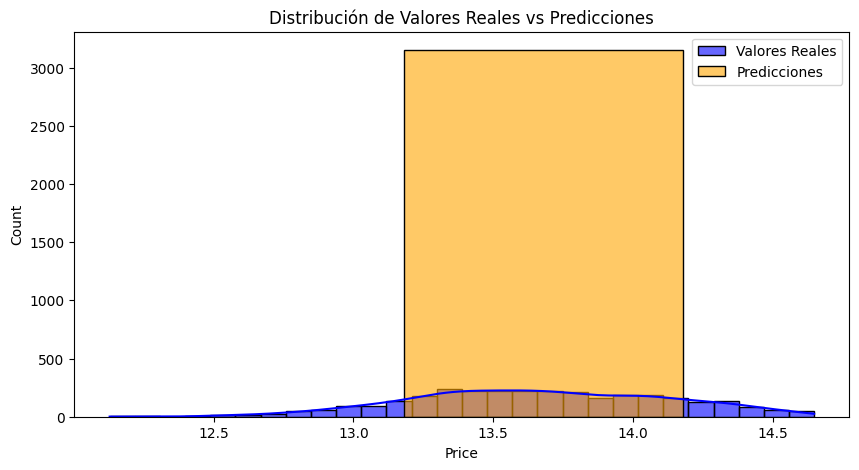

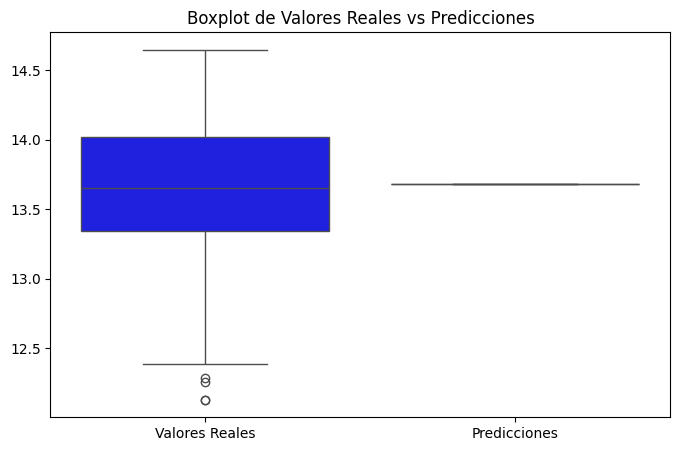

✅ elastic_net completado.
--------------------------------------------------
🔍 Entrenando modelo: ridge ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.17424131717518182
Prueba MAE: 0.16917402030279816
Entrenamiento MSE: 0.050496760375486345
Prueba MSE: 0.04650881450636874
Entrenamiento RMSE: 0.22471484235689984
Prueba RMSE: 0.21565902370726048
Entrenamiento R²: 0.7659447819443076
Prueba R²: 0.7745942267581931


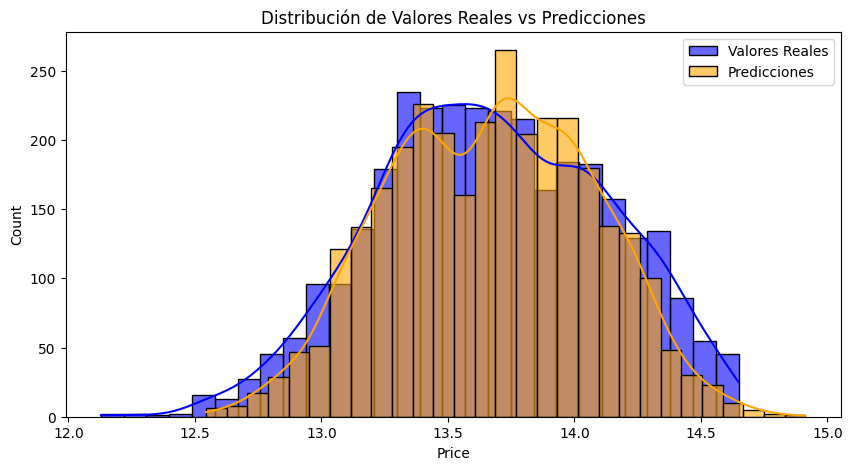

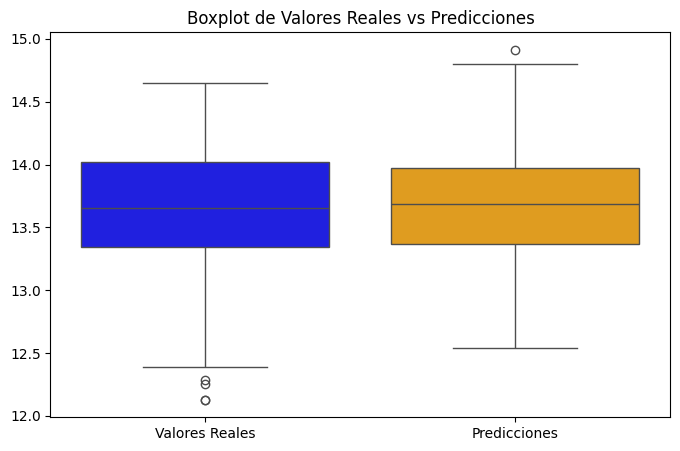

✅ ridge completado.
--------------------------------------------------
🔍 Entrenando modelo: lasso ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.38365114826867813
Prueba MAE: 0.374189645764438
Entrenamiento MSE: 0.2157472104017389
Prueba MSE: 0.2064389453757648
Entrenamiento RMSE: 0.4644859636218719
Prueba RMSE: 0.45435552750656044
Entrenamiento R²: 0.0
Prueba R²: -0.0005099163143669205


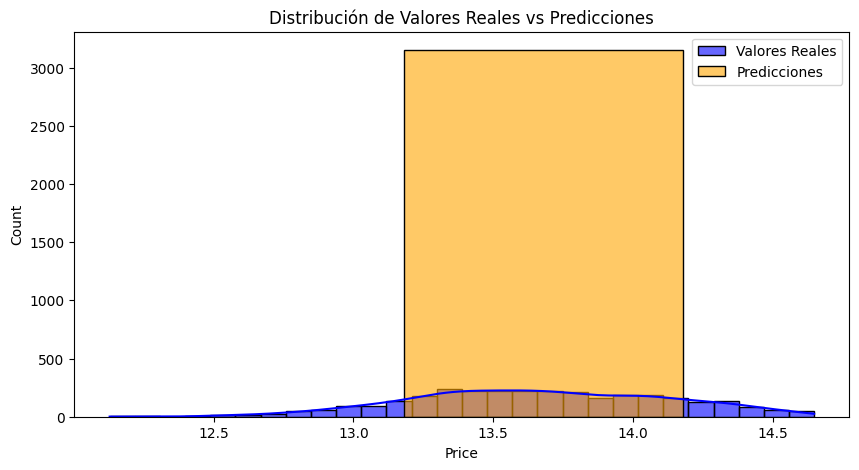

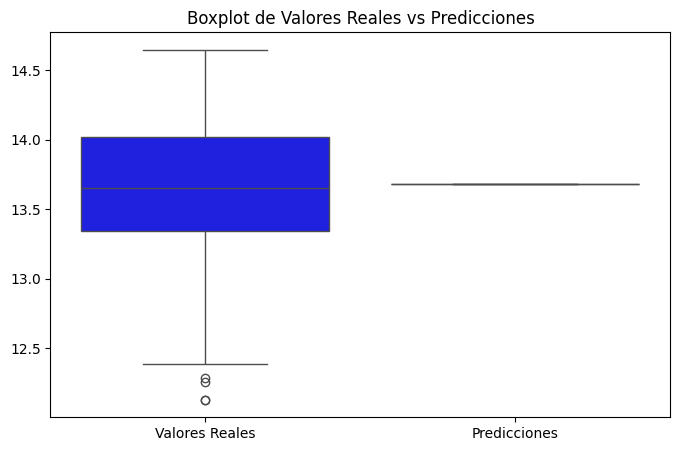

✅ lasso completado.
--------------------------------------------------
🔍 Entrenando modelo: decision_tree ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.002530652779731662
Prueba MAE: 0.034769106337688226
Entrenamiento MSE: 0.00041484125880666473
Prueba MSE: 0.011395824055286236
Entrenamiento RMSE: 0.020367652265459186
Prueba RMSE: 0.10675122507627834
Entrenamiento R²: 0.9980771883073983
Prueba R²: 0.9447699417804418


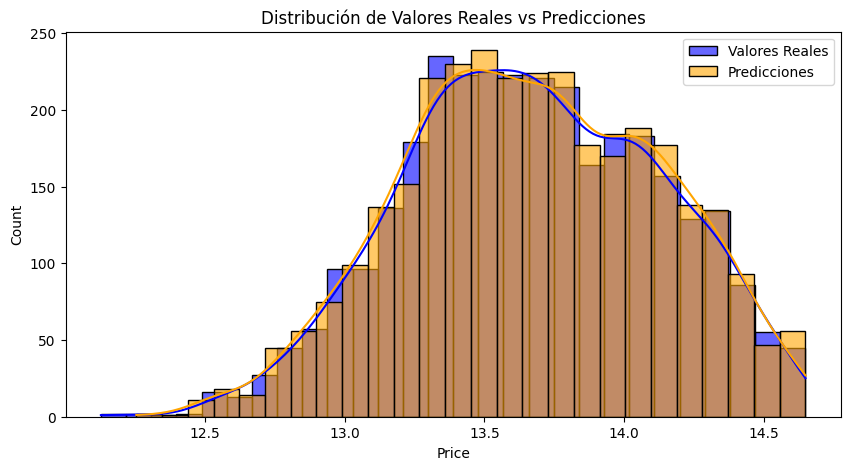

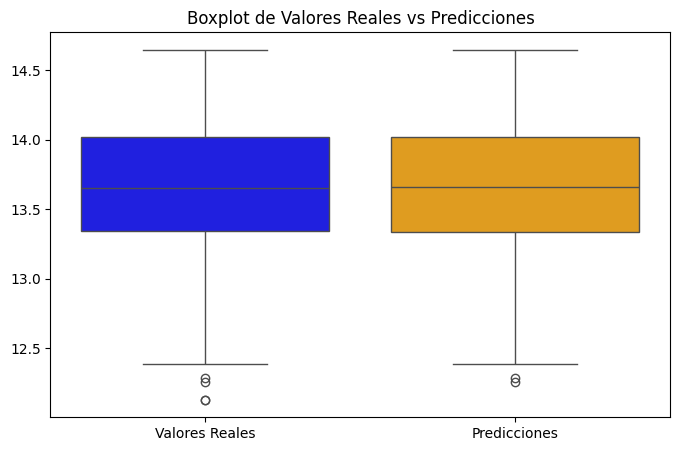

✅ decision_tree completado.
--------------------------------------------------
🔍 Entrenando modelo: random_forest ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.030740174055662237
Prueba MAE: 0.07319167399261092
Entrenamiento MSE: 0.0022919496269434873
Prueba MSE: 0.011480098678722931
Entrenamiento RMSE: 0.0478743107202964
Prueba RMSE: 0.10714522237936198
Entrenamiento R²: 0.9893766894011019
Prueba R²: 0.9443615033615738


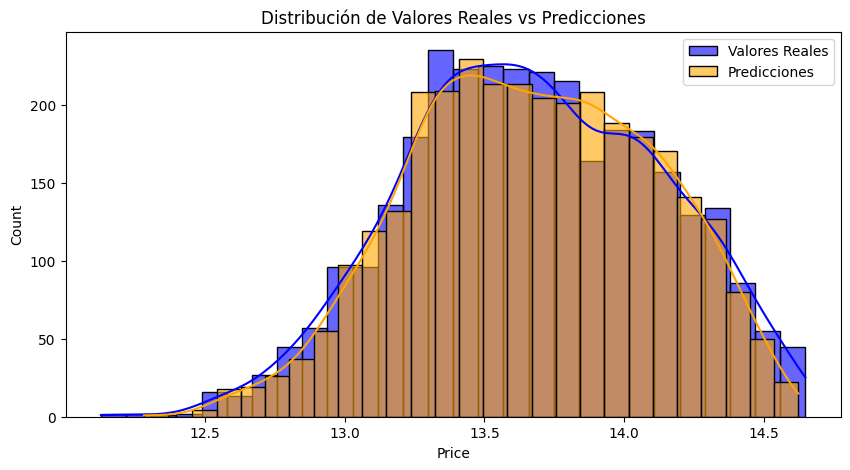

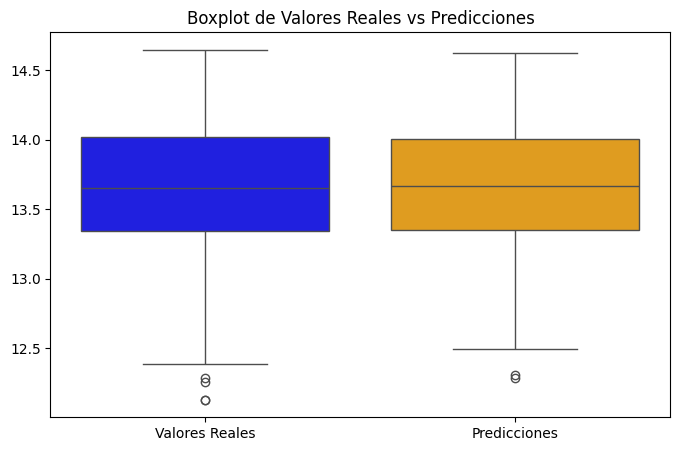

✅ random_forest completado.
--------------------------------------------------
🔍 Entrenando modelo: gradient_boosting ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.15889279238352974
Prueba MAE: 0.15474718595350404
Entrenamiento MSE: 0.042202080911820025
Prueba MSE: 0.03966609315431241
Entrenamiento RMSE: 0.2054314506394287
Prueba RMSE: 0.1991634834860859
Entrenamiento R²: 0.8043910703028961
Prueba R²: 0.8077575940426306


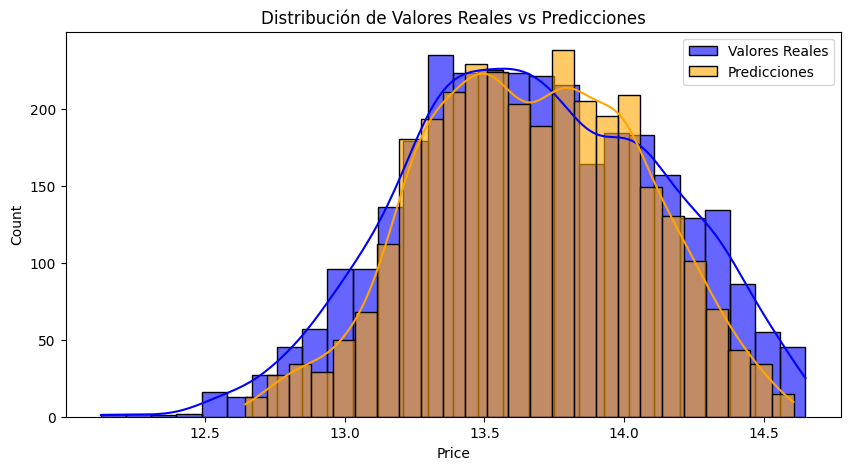

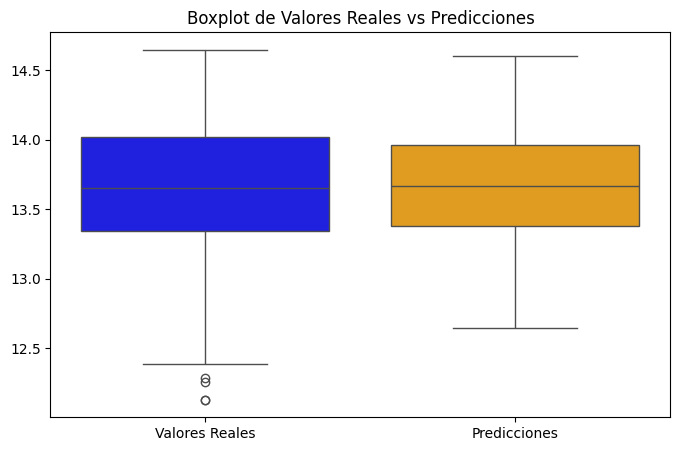

✅ gradient_boosting completado.
--------------------------------------------------
🔍 Entrenando modelo: svr ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.14169367414277984
Prueba MAE: 0.1425821866888522
Entrenamiento MSE: 0.03516825759177917
Prueba MSE: 0.034628935031376214
Entrenamiento RMSE: 0.18753201751108842
Prueba RMSE: 0.18608851396949844
Entrenamiento R²: 0.8369932221775057
Prueba R²: 0.8321702679345055


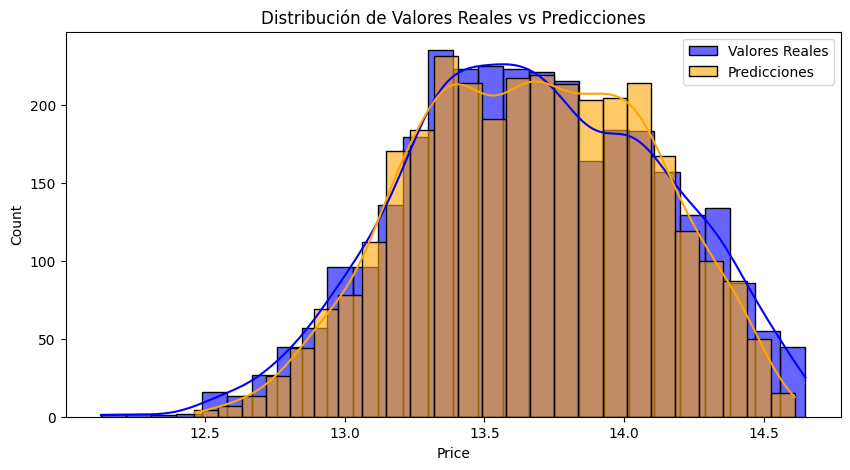

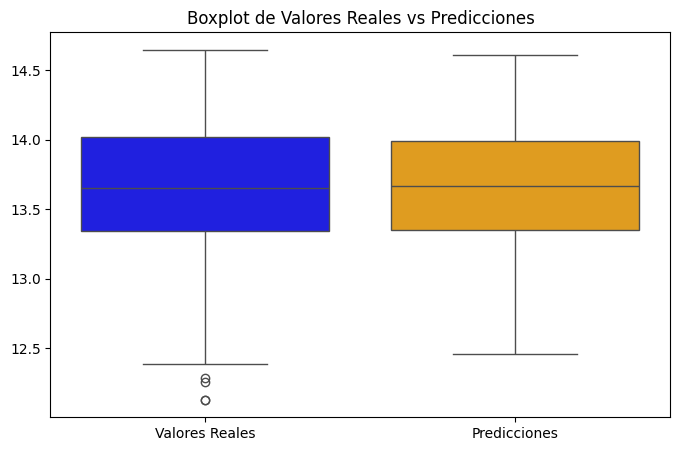

✅ svr completado.
--------------------------------------------------
🔍 Entrenando modelo: knn ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.11832475588882195
Prueba MAE: 0.14545571567763393
Entrenamiento MSE: 0.024657449098918954
Prueba MSE: 0.03662153279760101
Entrenamiento RMSE: 0.15702690565288152
Prueba RMSE: 0.19136753329026585
Entrenamiento R²: 0.8857113885597651
Prueba R²: 0.8225131084256495


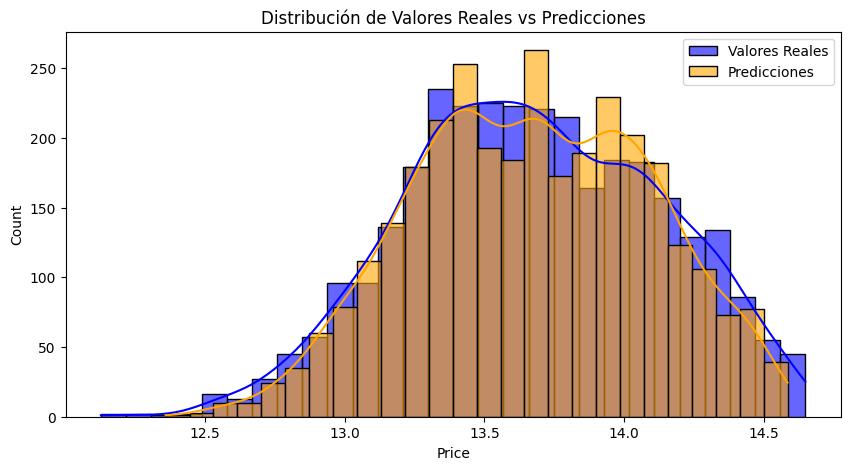

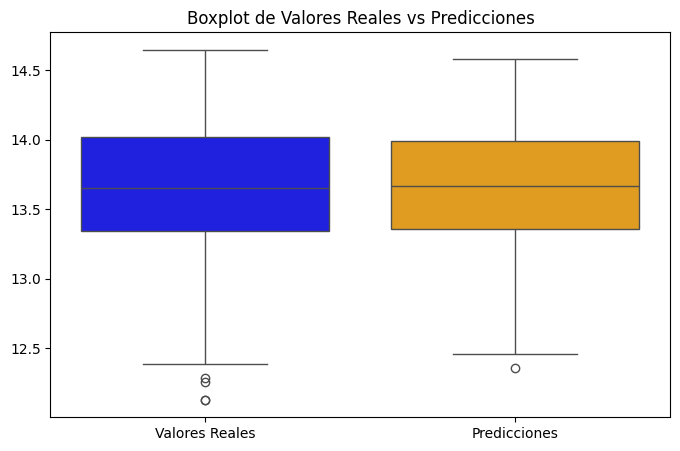

✅ knn completado.
--------------------------------------------------
🔍 Entrenando modelo: xgboost ...
📢 Media de y_train: 13.680127669311096
Entrenamiento MAE: 0.10456717046435399
Prueba MAE: 0.11993691292256324
Entrenamiento MSE: 0.019377182316738416
Prueba MSE: 0.024736999219101097
Entrenamiento RMSE: 0.1392019479631604
Prueba RMSE: 0.1572800026039582
Entrenamiento R²: 0.9101857109500673
Prueba R²: 0.8801117057950398


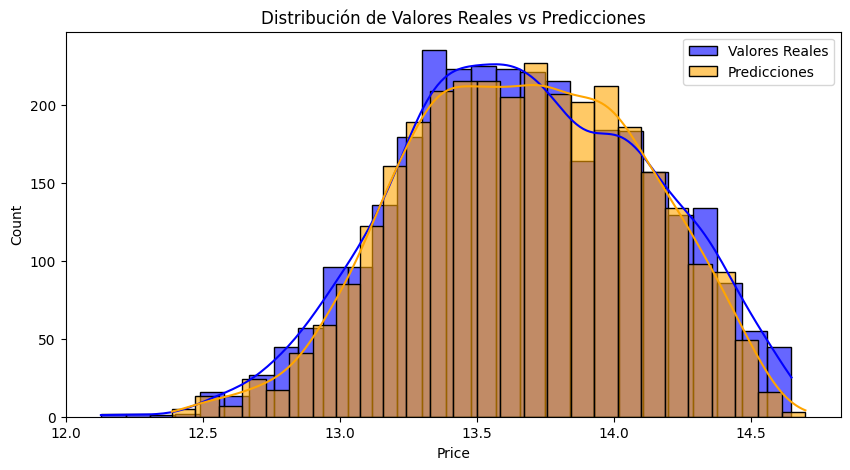

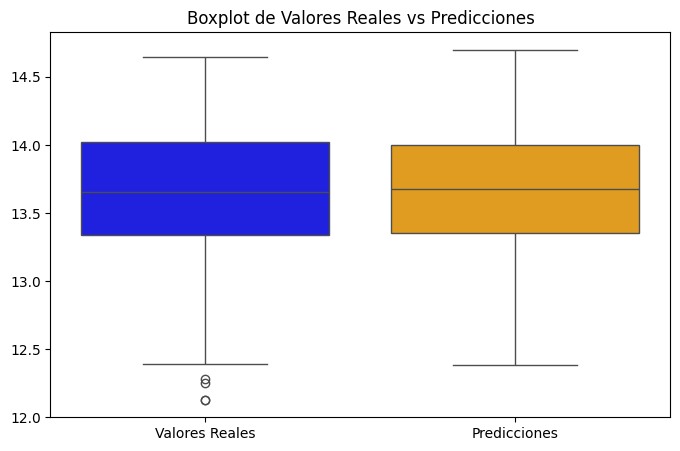

✅ xgboost completado.
--------------------------------------------------


In [16]:
# Entrenar y evaluar modelos
for model_name, model in models.items():
    print(f"🔍 Entrenando modelo: {model_name} ...")
    result_dict[model_name] = entrenar_modelo(
        modelo=model,  # ✅ Corrección aquí
        preprocessor=preprocessor,
        x_data=X_features,  # Usando la variable correcta para los datos de entrada
        y_data=Y_target,  # Usando la variable correcta para la variable objetivo
        test_frac=0.2,
    )
    print(f"✅ {model_name} completado.\n" + "-" * 50)

In [17]:
# Mostrar los resultados claramente con el nombre del modelo
for model_name in models:  # Asegurar que recorremos todos los modelos evaluados
    if model_name in result_dict:
        metrics = result_dict[model_name]
        print(f"--- {model_name.upper()} ---")  # Nombre del modelo en mayúsculas
        print("Train MAE:", metrics["Entrenamiento_MAE"])
        print("Test MAE:", metrics["Prueba_MAE"])
        print("Train MSE:", metrics["Entrenamiento_MSE"])
        print("Test MSE:", metrics["Prueba_MSE"])
        print("Train RMSE:", metrics["Entrenamiento_RMSE"])
        print("Test RMSE:", metrics["Prueba_RMSE"])
        print("Train R²:", metrics["Entrenamiento_R2"])
        print("Test R²:", metrics["Prueba_R2"])
    else:
        print(f"⚠️ {model_name.upper()} no tiene métricas registradas en result_dict.")

    print("-" * 50)  # Separador visual entre modelos

--- ELASTIC_NET ---
Train MAE: 0.38365114826867813
Test MAE: 0.374189645764438
Train MSE: 0.2157472104017389
Test MSE: 0.2064389453757648
Train RMSE: 0.4644859636218719
Test RMSE: 0.45435552750656044
Train R²: 0.0
Test R²: -0.0005099163143669205
--------------------------------------------------
--- RIDGE ---
Train MAE: 0.17424131717518182
Test MAE: 0.16917402030279816
Train MSE: 0.050496760375486345
Test MSE: 0.04650881450636874
Train RMSE: 0.22471484235689984
Test RMSE: 0.21565902370726048
Train R²: 0.7659447819443076
Test R²: 0.7745942267581931
--------------------------------------------------
--- LASSO ---
Train MAE: 0.38365114826867813
Test MAE: 0.374189645764438
Train MSE: 0.2157472104017389
Test MSE: 0.2064389453757648
Train RMSE: 0.4644859636218719
Test RMSE: 0.45435552750656044
Train R²: 0.0
Test R²: -0.0005099163143669205
--------------------------------------------------
--- DECISION_TREE ---
Train MAE: 0.002530652779731662
Test MAE: 0.034769106337688226
Train MSE: 0.000414

In [18]:
metrics = ["Entrenamiento_RMSE", "Entrenamiento_R2", "Prueba_RMSE", "Prueba_R2"]
models = list(result_dict.keys())

# Preparar datos para graficar
data_train = {
    metric: {model: result_dict[model][metric] for model in models}
    for metric in ["Entrenamiento_RMSE", "Entrenamiento_R2"]
}

data_test = {
    metric: {model: result_dict[model][metric] for model in models}
    for metric in ["Prueba_RMSE", "Prueba_R2"]
}

# Convertir en DataFrame
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)


print("📊 Métricas de Entrenamiento:")
display(df_train)

print("\n📊 Métricas de Prueba:")
display(df_test)

📊 Métricas de Entrenamiento:


,Entrenamiento_RMSE,Entrenamiento_R2
elastic_net,0.464486,0.000000
ridge,0.224715,0.765945
lasso,0.464486,0.000000
decision_tree,0.020368,0.998077
random_forest,0.047874,0.989377
gradient_boosting,0.205431,0.804391
svr,0.187532,0.836993
knn,0.157027,0.885711
xgboost,0.139202,0.910186



📊 Métricas de Prueba:


,Prueba_RMSE,Prueba_R2
elastic_net,0.454356,-0.000510
ridge,0.215659,0.774594
lasso,0.454356,-0.000510
decision_tree,0.106751,0.944770
random_forest,0.107145,0.944362
gradient_boosting,0.199163,0.807758
svr,0.186089,0.832170
knn,0.191368,0.822513
xgboost,0.157280,0.880112


### Selección de métricas

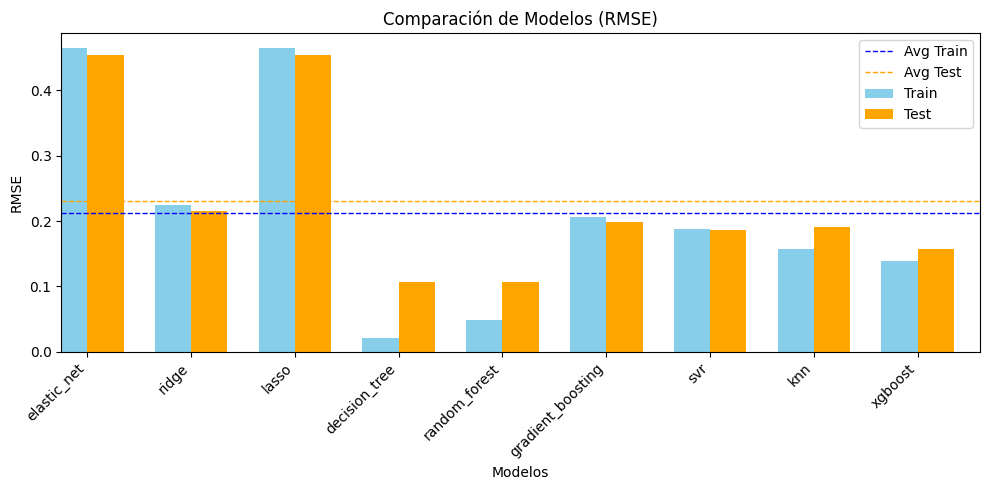

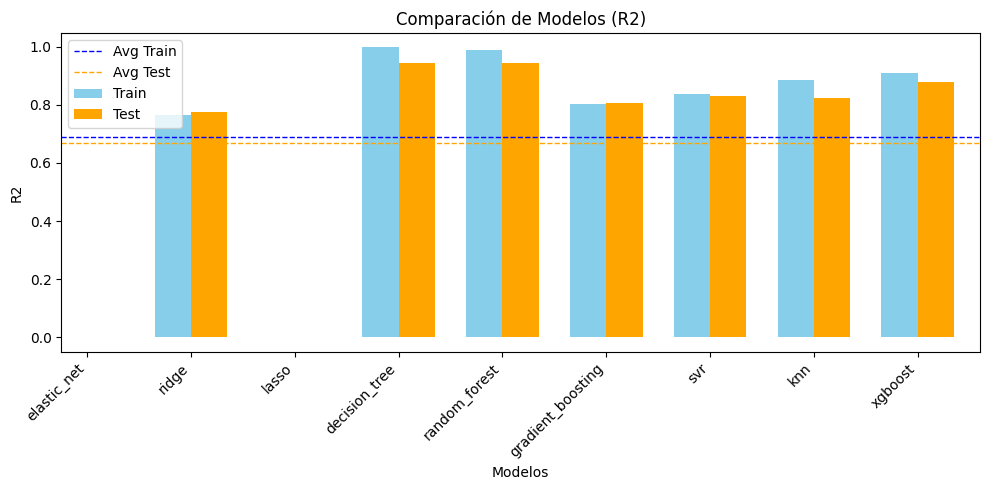

In [ ]:
# Definir las métricas que vamos a graficar
metrics = ["RMSE", "R2"]
models = df_train.index  # Usamos el índice del DataFrame para los modelos

# Graficar comparación de modelos para RMSE y R²
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    width = 0.35

    # Gráfica de barras para Entrenamiento y Prueba
    df_train[f"Entrenamiento_{metric}"].plot(
        kind="bar", ax=ax, width=width, position=1, label="Train", color="skyblue"
    )
    df_test[f"Prueba_{metric}"].plot(
        kind="bar", ax=ax, width=width, position=0, label="Test", color="orange"
    )

    # Líneas de promedios
    avg_train = df_train[f"Entrenamiento_{metric}"].mean()
    avg_test = df_test[f"Prueba_{metric}"].mean()
    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    # Personalizar el gráfico
    ax.set_title(f"Comparación de Modelos ({metric})")
    ax.set_ylabel(metric)
    ax.set_xlabel("Modelos")
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha="right")

    plt.legend()
    plt.tight_layout()
    plt.show()

### Ver cuales modelos tienen sobreajuste, subasjute y cuales son estables

In [ ]:
# Crear un DataFrame combinado con métricas de entrenamiento y prueba
df_combined = pd.concat(
    [df_train.add_suffix("_Entrenamiento"), df_test.add_suffix("_Prueba")], axis=1
)

# 🔎 Verifica las columnas disponibles
print("Columnas en df_combined:", df_combined.columns.tolist())

# Ajustar los nombres correctos según lo que realmente existe en el DataFrame
col_rmse_train = next(col for col in df_combined.columns if "RMSE_Entrenamiento" in col)
col_rmse_test = next(col for col in df_combined.columns if "RMSE_Prueba" in col)
col_r2_train = next(col for col in df_combined.columns if "R2_Entrenamiento" in col)
col_r2_test = next(col for col in df_combined.columns if "R2_Prueba" in col)

# Calcular diferencias entre entrenamiento y prueba para detectar sobreajuste
df_combined["RMSE_Diferencia"] = np.abs(df_combined[col_rmse_train] - df_combined[col_rmse_test])
df_combined["R2_Diferencia"] = np.abs(df_combined[col_r2_train] - df_combined[col_r2_test])

# Definir umbrales para identificar sobreajuste y bajo rendimiento
umbral_sobreajuste = 0.2  # Diferencia de R² para considerar sobreajuste
umbral_bajo_rendimiento = df_combined[
    col_r2_test
].mean()  # R² promedio como referencia de bajo rendimiento

# Identificar modelos con sobreajuste
modelos_sobreajuste = df_combined[
    df_combined[col_r2_train] - df_combined[col_r2_test] > umbral_sobreajuste
]

# Identificar modelos con bajo rendimiento
modelos_bajo_rendimiento = df_combined[df_combined[col_r2_test] < umbral_bajo_rendimiento]

# Mostrar resumen de modelos detectados
print(f"📌 Modelos con sobreajuste: {list(modelos_sobreajuste.index)}")
print(f"⚠️ Modelos con bajo rendimiento: {list(modelos_bajo_rendimiento.index)}")

Columnas en df_combined: ['Entrenamiento_RMSE_Entrenamiento', 'Entrenamiento_R2_Entrenamiento', 'Prueba_RMSE_Prueba', 'Prueba_R2_Prueba']
📌 Modelos con sobreajuste: []
⚠️ Modelos con bajo rendimiento: ['elastic_net', 'lasso']


In [ ]:
# Definir el umbral para considerar un modelo con rendimiento estable
umbral_rendimiento_estable = 0.05  # Si la diferencia de R² es menor, se considera estable

# Buscar la columna correcta con la diferencia de R²
col_r2_diff = "R2_Diferencia"  # Asegurar que el nombre coincide

# Verificar las columnas disponibles antes de ejecutar el filtro
print("🔍 Columnas en df_combined:", df_combined.columns.tolist())

# Excluir los modelos con bajo rendimiento antes de analizar estabilidad
modelos_filtrados = df_combined.drop(index=modelos_bajo_rendimiento.index, errors="ignore")

# Filtrar los modelos con diferencia de R² menor al umbral
if col_r2_diff in modelos_filtrados.columns:
    modelos_rendimiento_estable = modelos_filtrados[
        modelos_filtrados[col_r2_diff] < umbral_rendimiento_estable
    ]

    print(f"Modelos con rendimiento estable: {list(modelos_rendimiento_estable.index)}")
else:
    print(
        f"⚠️ No se encontró la columna '{col_r2_diff}' en df_combined. "
        "Revisa los nombres de columnas."
    )

🔍 Columnas en df_combined: ['Entrenamiento_RMSE_Entrenamiento', 'Entrenamiento_R2_Entrenamiento', 'Prueba_RMSE_Prueba', 'Prueba_R2_Prueba', 'RMSE_Diferencia', 'R2_Diferencia']
📊 Modelos con rendimiento estable entre entrenamiento y prueba (sin bajo rendimiento): ['ridge', 'random_forest', 'gradient_boosting', 'svr', 'xgboost']


In [22]:
modelos_sobreajuste

,Entrenamiento_RMSE_Entrenamiento,Entrenamiento_R2_Entrenamiento,Prueba_RMSE_Prueba,Prueba_R2_Prueba,RMSE_Diferencia,R2_Diferencia


In [23]:
modelos_bajo_rendimiento

,Entrenamiento_RMSE_Entrenamiento,Entrenamiento_R2_Entrenamiento,Prueba_RMSE_Prueba,Prueba_R2_Prueba,RMSE_Diferencia,R2_Diferencia
elastic_net,0.464486,0.0,0.454356,-0.00051,0.01013,0.00051
lasso,0.464486,0.0,0.454356,-0.00051,0.01013,0.00051


In [24]:
modelos_rendimiento_estable

,Entrenamiento_RMSE_Entrenamiento,Entrenamiento_R2_Entrenamiento,Prueba_RMSE_Prueba,Prueba_R2_Prueba,RMSE_Diferencia,R2_Diferencia
ridge,0.224715,0.765945,0.215659,0.774594,0.009056,0.008649
random_forest,0.047874,0.989377,0.107145,0.944362,0.059271,0.045015
gradient_boosting,0.205431,0.804391,0.199163,0.807758,0.006268,0.003367
svr,0.187532,0.836993,0.186089,0.832170,0.001444,0.004823
xgboost,0.139202,0.910186,0.157280,0.880112,0.018078,0.030074


In [25]:
models = {
    "ridge": Ridge(random_state=42),
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "svr": SVR(),
    "xgboost": XGBRegressor(random_state=42),
}

# Métricas de evaluación para regresión
scoring_metrics = ["neg_root_mean_squared_error", "r2"]

# KFold para validación cruzada
kfold = KFold(n_splits=10, shuffle=True, random_state=1234)

# Diccionario para almacenar los resultados de la validación cruzada
cv_results = {metric: {} for metric in scoring_metrics}

# Realizar validación cruzada para cada modelo y métrica
for model_name, model in models.items():
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    for metric in scoring_metrics:
        scores = cross_val_score(model_pipe, x_train, y_train, cv=kfold, scoring=metric)
        cv_results[metric][model_name] = scores

# Convertir los resultados en DataFrames para cada métrica
cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}

In [ ]:
# Crear un DataFrame para almacenar la media y desviación estándar de cada métrica y modelo
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in [
        "ridge",
        "random_forest",
        "gradient_boosting",
        "svr",
        "xgboost",  # Modelos con rendimiento estable
    ]:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append(
            {
                "Modelo": model_name,
                "Métrica": metric_name,
                "Media": mean_score,
                "Desviación estándar": std_score,
            }
        )

# Convertir a DataFrame
mean_std_df = pd.DataFrame(mean_std_data)
mean_std_df

,Modelo,Métrica,Media,Desviación estándar
0,ridge,neg_root_mean_squared_error,-0.225518,0.005342
1,random_forest,neg_root_mean_squared_error,-0.128027,0.006351
2,gradient_boosting,neg_root_mean_squared_error,-0.209870,0.005087
3,svr,neg_root_mean_squared_error,-0.197192,0.004308
4,xgboost,neg_root_mean_squared_error,-0.167117,0.006340
5,ridge,r2,0.763859,0.009196
6,random_forest,r2,0.923652,0.008500
7,gradient_boosting,r2,0.795311,0.012147
8,svr,r2,0.819423,0.007496
9,xgboost,r2,0.870058,0.011443


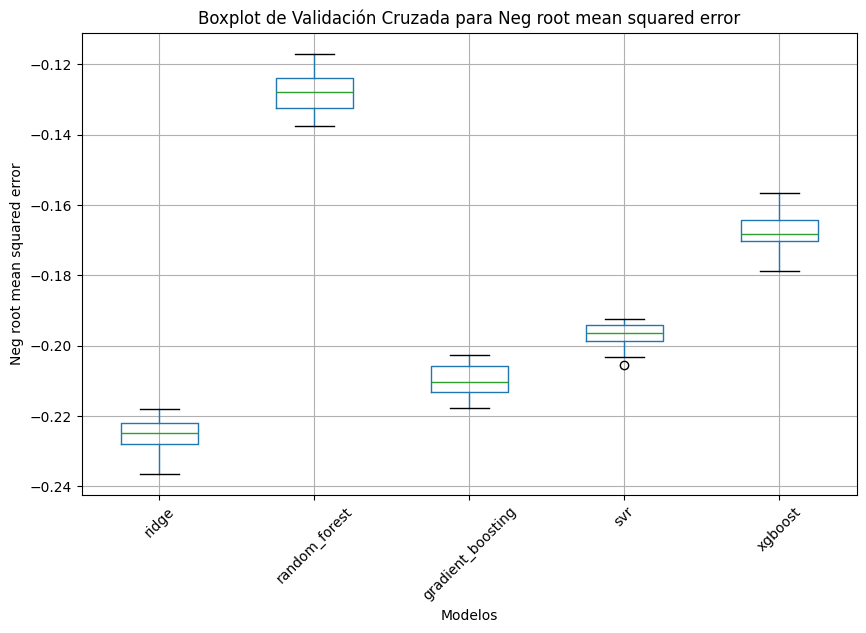

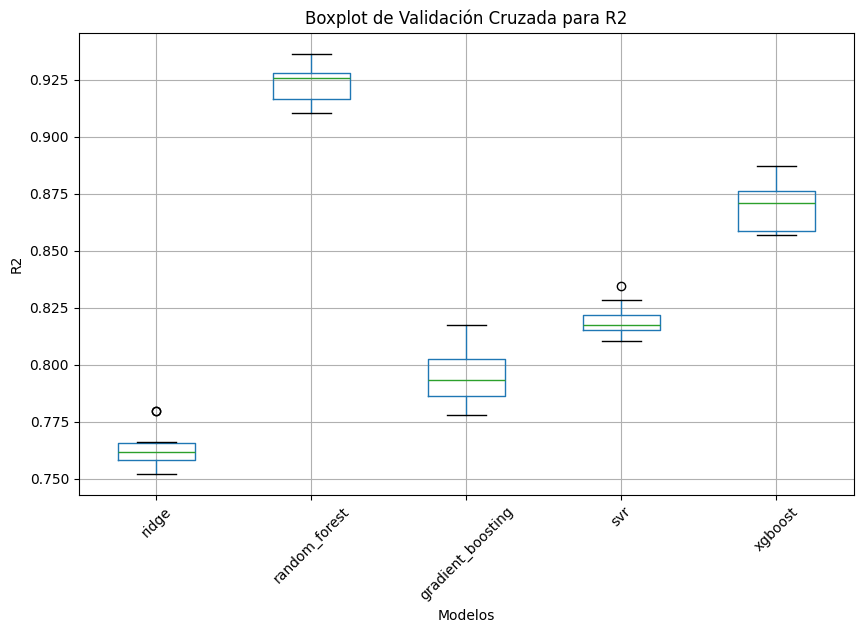

In [27]:
# Crear un boxplot para los resultados de validación cruzada de cada métrica de regresión
for metric_name in scoring_metrics:
    plt.figure(figsize=(10, 6))

    # Filtrar solo los modelos con rendimiento estable
    stable_models = ["ridge", "random_forest", "gradient_boosting", "svr", "xgboost"]
    cv_results_df[metric_name][stable_models].boxplot()

    plt.title(f"Boxplot de Validación Cruzada para {metric_name.replace('_', ' ').capitalize()}")
    plt.ylabel(f"{metric_name.replace('_', ' ').capitalize()}")
    plt.xlabel("Modelos")
    plt.xticks(rotation=45)

    plt.show()

### Para evaluar la calidad del ajuste de los modelos, se optó por utilizar el coeficiente de determinación (R²) en lugar de métricas como el RMSE o MAE. La razón principal es que el R² mide qué tan bien el modelo explica la variabilidad de los datos, lo cual es clave cuando se busca optimizar el ajuste a la realidad sin caer en sobreajuste o subajuste.

- A diferencia del RMSE, el R² es escalable, lo que permite comparar modelos en diferentes contextos

In [28]:
result_df = cv_results_df["r2"]
result_df

,ridge,random_forest,gradient_boosting,svr,xgboost
0,0.752097,0.918796,0.785248,0.816014,0.857117
1,0.759392,0.910257,0.777827,0.810567,0.857954
2,0.763519,0.928720,0.803282,0.821390,0.869118
3,0.759131,0.926503,0.800398,0.822105,0.876673
4,0.765926,0.915007,0.785394,0.815235,0.861498
5,0.779491,0.936444,0.807845,0.828395,0.886250
6,0.757731,0.926485,0.789296,0.815385,0.873080
7,0.779832,0.933817,0.817464,0.834686,0.887241
8,0.757618,0.924747,0.797657,0.818553,0.874319
9,0.763853,0.915745,0.788697,0.811901,0.857334


In [29]:
# Select the metric to analyze (RMSE, since it is our primary evaluation metric)
result_df = cv_results_df["neg_root_mean_squared_error"]

# Extract RMSE results for each model
model1 = result_df["ridge"]
model2 = result_df["random_forest"]
model3 = result_df["gradient_boosting"]
model4 = result_df["svr"]
model5 = result_df["xgboost"]

# Perform ANOVA test
statistic, p_value = f_oneway(model1, model2, model3, model4, model5)

print(f"Statistic: {statistic}")
print(f"p_value: {p_value}")

# Set significance level
alpha = 0.05

if p_value < alpha:
    print(
        "There is a statistically significant difference "
        "in the cross-validation RMSE results of the models."
    )
else:
    print(
        "There is no statistically significant difference "
        "in the cross-validation RMSE results of the models."
    )

Statistic: 486.3878723136403
p_value: 2.1475541265234193e-36
There is a statistically significant difference in the cross-validation RMSE results of the models.


In [30]:
# Definir la métrica de evaluación (R² porque queremos optimizar la calidad del ajuste)
score = "r2"

# Hiperparámetros optimizados para SVR
parametros_svr = {
    "model__C": [0.1, 1, 10],  # Valores optimizados para reducir combinaciones
    "model__epsilon": [0.01, 0.1],  # Reducimos el número de valores
    "model__kernel": ["linear", "rbf"],  # Quitamos 'poly' ya que es costoso computacionalmente
}

# Definir el pipeline con preprocesamiento y el modelo SVR
svr_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", SVR())])

# Implementar búsqueda de hiperparámetros usando HalvingGridSearchCV
halving_grid_search_svr = HalvingGridSearchCV(
    svr_pipeline,
    parametros_svr,
    factor=2,  # Reduce progresivamente las combinaciones evaluadas
    cv=3,  # Menos folds en validación cruzada para acelerar búsqueda
    scoring=score,
    return_train_score=True,
    n_jobs=-1,
)

# Ajustar el modelo a los datos de entrenamiento
halving_grid_search_svr.fit(x_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros para SVR: {halving_grid_search_svr.best_params_}")

# Obtener el mejor modelo entrenado con los mejores parámetros
mejor_modelo_svr = halving_grid_search_svr.best_estimator_

/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mejores parámetros para SVR: {'model__C': 1, 'model__epsilon': 0.1, 'model__kernel': 'rbf'}


In [31]:
print(f"Mejores parámetros para SVR: {halving_grid_search_svr.best_params_}")

Mejores parámetros para SVR: {'model__C': 1, 'model__epsilon': 0.1, 'model__kernel': 'rbf'}


In [32]:
# Entrenar el modelo final de SVR con los mejores hiperparámetros encontrados
best_svr_model = SVR(C=1, epsilon=0.1, kernel="rbf")

svr_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_svr_model)])
svr_final_model = svr_pipe.fit(x_train, y_train)

In [ ]:
# Definir la métrica de evaluación (R² porque queremos optimizar la calidad del ajuste)
score = "r2"

# Hiperparámetros optimizados para XGBoost
parametros_xgb = {
    "model__n_estimators": [100, 300, 500],  # Número de árboles
    "model__learning_rate": [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    "model__max_depth": [3, 5, 7],  # Profundidad máxima de los árboles
}

# Definir el pipeline con preprocesamiento y el modelo XGBoost
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(random_state=42)),
    ]
)

# Implementar búsqueda de hiperparámetros usando HalvingGridSearchCV
halving_grid_search_xgb = HalvingGridSearchCV(
    xgb_pipeline,
    parametros_xgb,
    factor=2,  # Reduce progresivamente las combinaciones evaluadas
    cv=3,  # Menos folds en validación cruzada para acelerar búsqueda
    scoring=score,
    return_train_score=True,
    n_jobs=-1,
)

# Ajustar el modelo a los datos de entrenamiento
halving_grid_search_xgb.fit(x_train, y_train)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros para XGBoost: {halving_grid_search_xgb.best_params_}")

# Obtener el mejor modelo entrenado con los mejores parámetros
mejor_modelo_xgb = halving_grid_search_xgb.best_estimator_

/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mejores parámetros para XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}


In [34]:
print(f"Mejores parámetros para XGBoost: {halving_grid_search_xgb.best_params_}")

Mejores parámetros para XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}


In [35]:
# Entrenar el modelo XGBoost final con los mejores hiperparámetros encontrados
best_xgb_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=300,  # Usando el mejor valor encontrado en la búsqueda de hiperparámetros
    objective="reg:squarederror",
    random_state=42,
)

# Crear el pipeline con preprocesamiento y el modelo XGBoost final
xgb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_xgb_model)])

# Ajustar el modelo a los datos de entrenamiento
xgb_final_model = xgb_pipe.fit(x_train, y_train)

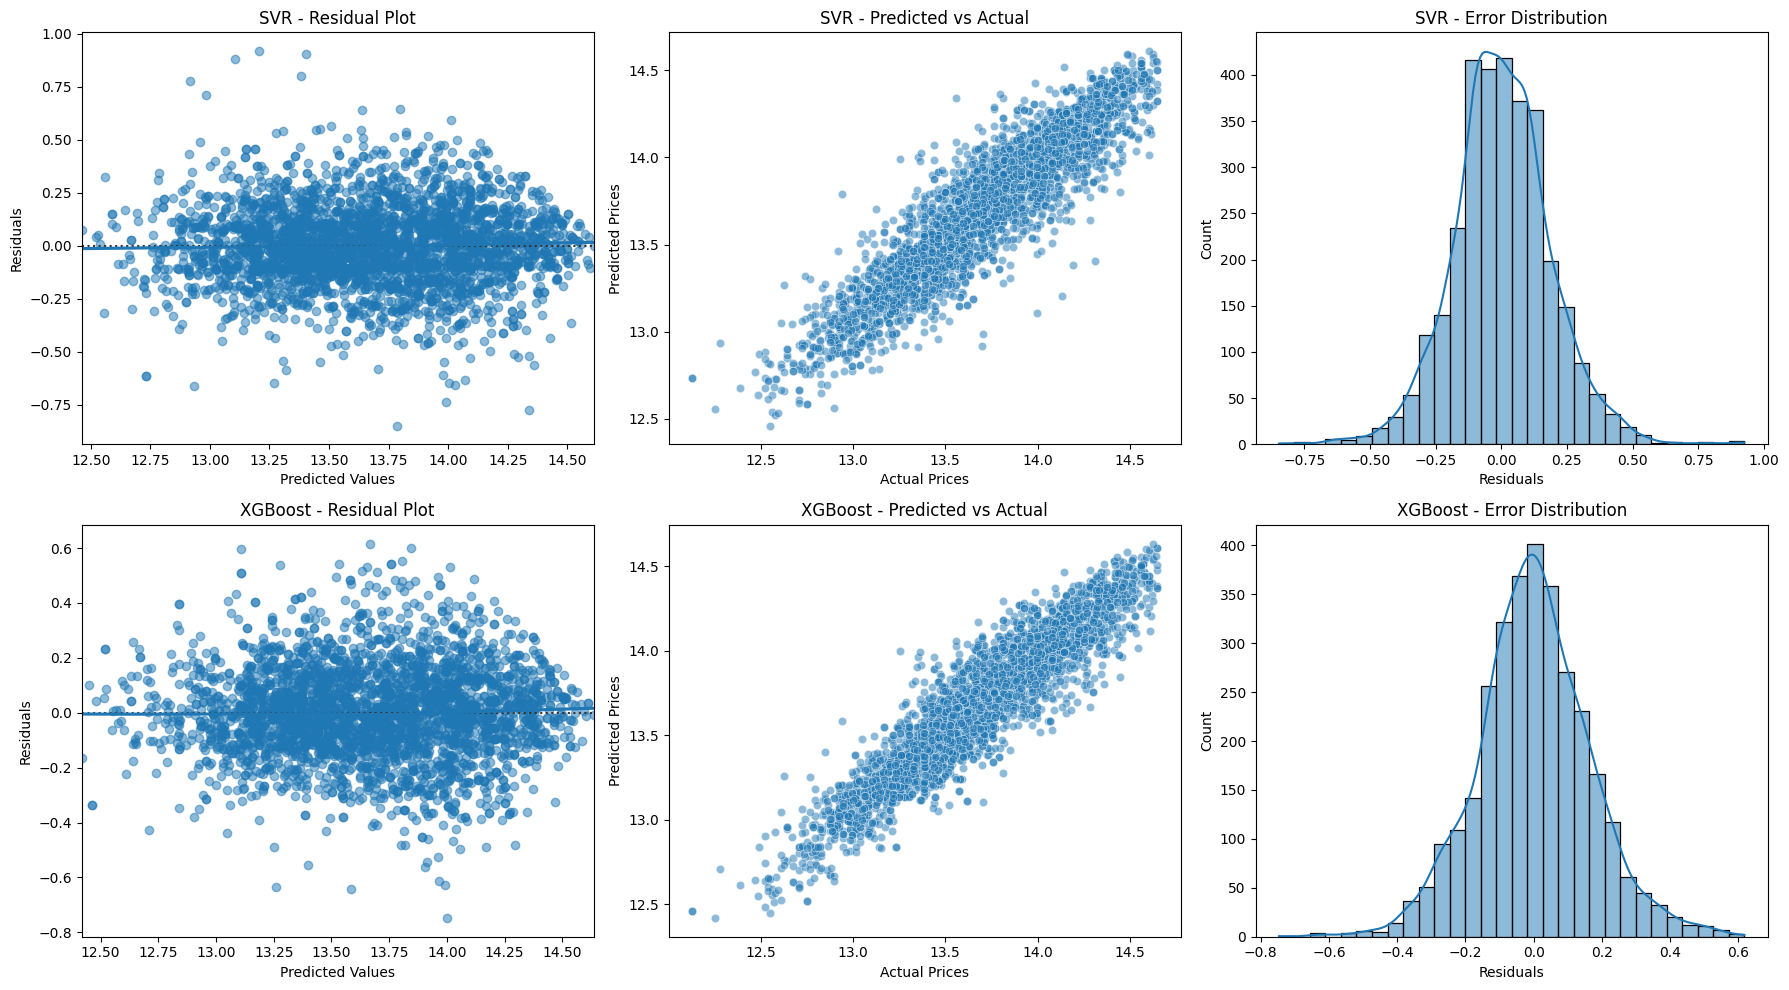

In [ ]:
# Predicciones con los modelos optimizados
y_pred_svr = mejor_modelo_svr.predict(x_test)
y_pred_xgb = xgb_final_model.predict(x_test)

# Crear subgráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 📌 1. Gráfico de Residuales (Error vs. Valores Predichos)
sns.residplot(
    x=y_pred_svr,
    y=(y_test - y_pred_svr),
    ax=axes[0, 0],
    lowess=True,
    scatter_kws={"alpha": 0.5},
)
axes[0, 0].set_title("SVR - Residual Plot")
axes[0, 0].set_xlabel("Predicted Values")
axes[0, 0].set_ylabel("Residuals")

sns.residplot(
    x=y_pred_xgb,
    y=(y_test - y_pred_xgb),
    ax=axes[1, 0],
    lowess=True,
    scatter_kws={"alpha": 0.5},
)
axes[1, 0].set_title("XGBoost - Residual Plot")
axes[1, 0].set_xlabel("Predicted Values")
axes[1, 0].set_ylabel("Residuals")

# 📌 2. Comparación de Valores Predichos vs Reales
sns.scatterplot(x=y_test, y=y_pred_svr, ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_title("SVR - Predicted vs Actual")
axes[0, 1].set_xlabel("Actual Prices")
axes[0, 1].set_ylabel("Predicted Prices")

sns.scatterplot(x=y_test, y=y_pred_xgb, ax=axes[1, 1], alpha=0.5)
axes[1, 1].set_title("XGBoost - Predicted vs Actual")
axes[1, 1].set_xlabel("Actual Prices")
axes[1, 1].set_ylabel("Predicted Prices")

# 📌 3. Distribución del Error (Histograma de Residuales)
sns.histplot(y_test - y_pred_svr, kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title("SVR - Error Distribution")
axes[0, 2].set_xlabel("Residuals")

sns.histplot(y_test - y_pred_xgb, kde=True, bins=30, ax=axes[1, 2])
axes[1, 2].set_title("XGBoost - Error Distribution")
axes[1, 2].set_xlabel("Residuals")

# Ajustar diseño de los gráficos
plt.tight_layout()
plt.show()

/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/workspaces/CDP-Melbourne-houses/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


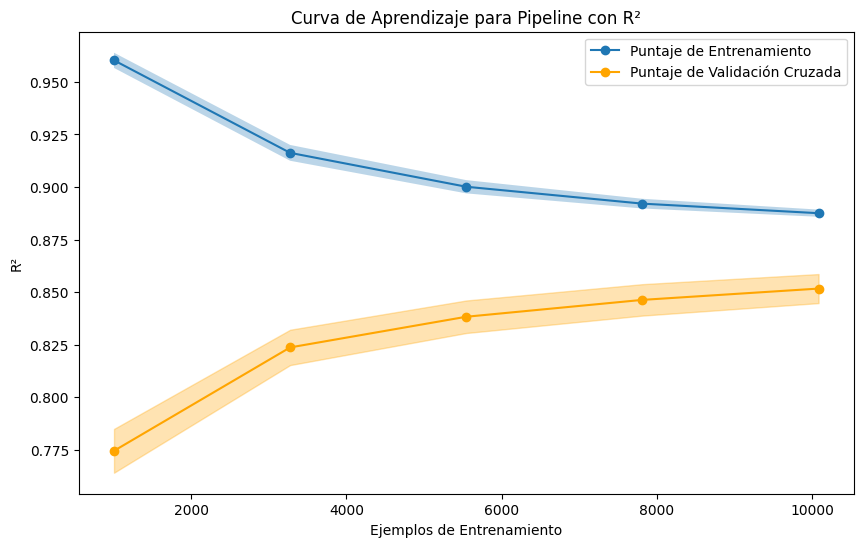

Tamaños de Entrenamiento: [ 1008  3276  5544  7812 10080]
Media de Puntajes de Entrenamiento: [0.9602306  0.91623212 0.90011257 0.89208128 0.88753706]
Desviación Estándar de Entrenamiento: [0.00361223 0.00376165 0.00315098 0.00230696 0.00170783]
Media de Puntajes de Validación: [0.77454631 0.82371844 0.83830041 0.84632102 0.85169307]
Desviación Estándar de Validación: [0.01041104 0.00839938 0.00773455 0.00747458 0.0069091 ]


In [37]:
# Definir el modelo XGBoost con los mejores hiperparámetros
modelo = xgb_final_model

# Parámetros comunes para la curva de aprendizaje
parametros_comunes = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

# Métrica de evaluación: R²
metrica_evaluacion = "r2"

# Obtener los valores de la curva de aprendizaje, incluyendo tiempos de ajuste y puntuación
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    modelo, **parametros_comunes, scoring=metrica_evaluacion
)

# Calcular la media y desviación estándar de los puntajes
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calcular la media y desviación estándar de los tiempos de ajuste y evaluación
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Graficar la curva de aprendizaje
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, "o-", label="Puntaje de Entrenamiento")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Puntaje de Validación Cruzada")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange")

# Configuración del gráfico
ax.set_title(f"Curva de Aprendizaje para {modelo.__class__.__name__} con R²")
ax.set_xlabel("Ejemplos de Entrenamiento")
ax.set_ylabel("R²")
ax.legend(loc="best")

# Mostrar la gráfica
plt.show()

# Imprimir los valores obtenidos para análisis
print("Tamaños de Entrenamiento:", train_sizes)
print("Media de Puntajes de Entrenamiento:", train_mean)
print("Desviación Estándar de Entrenamiento:", train_std)
print("Media de Puntajes de Validación:", test_mean)
print("Desviación Estándar de Validación:", test_std)

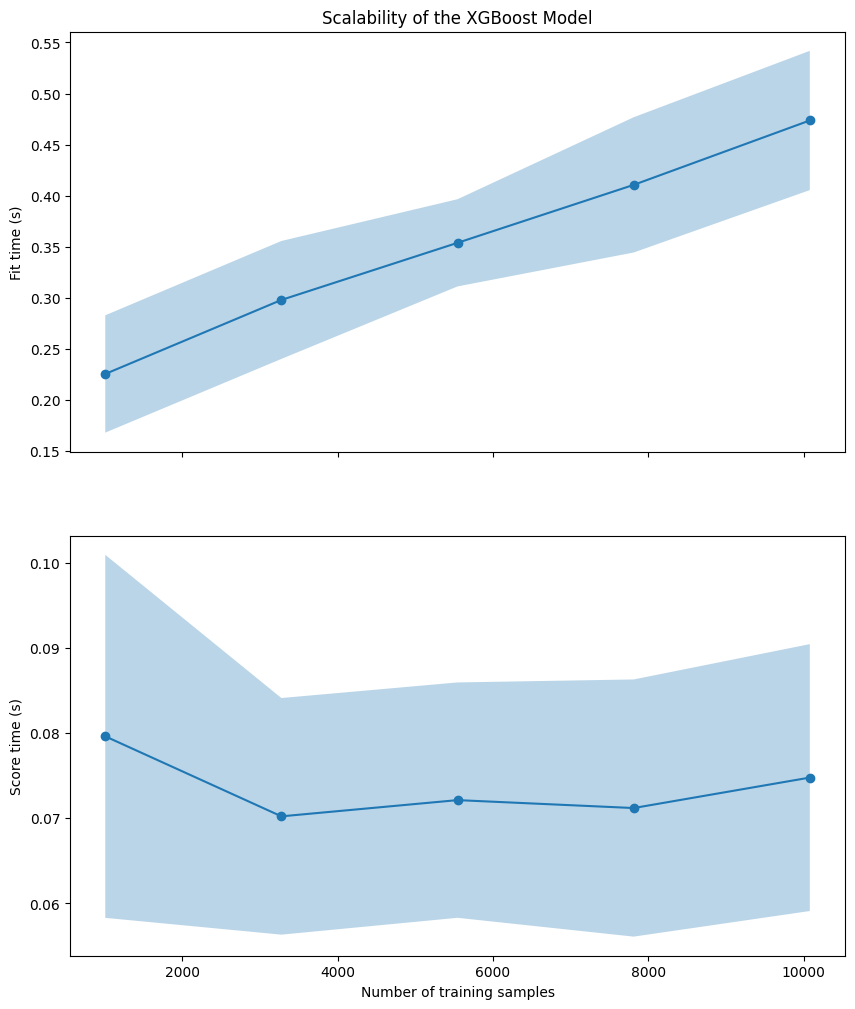

Fit Times Mean: [0.22528729 0.29779343 0.35374439 0.41050532 0.47361451]
Fit Times Std: [0.05746917 0.05776883 0.04271776 0.06625072 0.06821986]
Score Times Mean: [0.07962728 0.07023266 0.07213726 0.07120736 0.07478399]
Score Times Std: [0.02131533 0.01389428 0.01382012 0.01510049 0.01567056]


In [38]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the XGBoost Model")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

In [ ]:
# Guardar el pipeline completo (preprocesamiento + modelo XGBoost)
dump(xgb_final_model, "melbourne_houses_regression-xgboost.joblib")

print(
    "✅ Modelo XGBoost guardado exitosamente como 'melbourne_houses_regression-xgboost-v1.joblib'"
)

✅ Modelo XGBoost guardado exitosamente como 'melbourne_houses_regression-xgboost-v1.joblib'


In [40]:
# Cargar el modelo guardado (preprocesamiento + XGBoost)
melbourne_model = load("melbourne_houses_regression-xgboost.joblib")

print("✅ Modelo XGBoost cargado exitosamente.")

# Seleccionar un subconjunto de datos de prueba para hacer predicciones
df_test = x_test.sample(5, random_state=42)

# Mostrar los datos seleccionados
df_test

✅ Modelo XGBoost cargado exitosamente.


,Rooms,Bedroom2,Bathroom,YearBuilt,BuildingArea,Type,Regionname,CouncilArea,Method
6156,2.0,2.0,1.0,1920.0,106.2,h,Northern Metropolitan,Darebin City Council,S
47075,3.0,3.0,1.0,1900.0,120.0,h,Northern Metropolitan,Melbourne City Council,S
45135,3.0,3.0,1.0,1975.0,103.0,h,Northern Metropolitan,Whittlesea City Council,S
22314,3.0,3.0,1.0,1910.0,122.0,h,Northern Metropolitan,Darebin City Council,S
46578,4.0,4.0,2.0,1940.0,199.0,h,Southern Metropolitan,Glen Eira City Council,S


In [41]:
# Make predictions with the loaded model
predictions = melbourne_model.predict(df_test)

# Display the predictions
print("Predictions for first test samples:", predictions)

Predictions for first test samples: [13.930063 14.061085 13.29171  13.992047 14.261651]


## 🔍 **Selección de la Métrica de Evaluación: R²**
Para evaluar la calidad del ajuste de los modelos, se optó por utilizar el **coeficiente de determinación (R²)** en lugar de métricas como el RMSE o MAE. La razón principal es que el **R² mide qué tan bien el modelo explica la variabilidad de los datos**, lo cual es clave cuando se busca optimizar el ajuste a la realidad sin caer en sobreajuste o subajuste. Además:

- A diferencia del RMSE, el **R² es escalable**, lo que permite comparar modelos en diferentes contextos sin depender de la magnitud de la variable objetivo.

## 🏆 **Comparación de Modelos: SVR vs XGBoost**
Se evaluaron varios modelos de regresión, incluyendo **ElasticNet, Ridge, Lasso, Decision Tree, Random Forest, Gradient Boosting, SVR y XGBoost**. Al revisar los resultados:

1. **ElasticNet y Lasso** obtuvieron **R² ≈ 0**, lo que indica que no explican la variabilidad de los datos.
2. **Decision Tree y Random Forest** lograron un **R² muy alto en entrenamiento (≈ 0.99), pero menor en prueba (≈ 0.94)**, lo que sugiere **sobreajuste**.
3. **Gradient Boosting** mostró un **R² en prueba de 0.807**, con un rendimiento estable, pero menor que SVR y XGBoost.
4. **SVR** obtuvo un **R² de 0.832 en prueba**, con valores estables y una dispersión moderada en la distribución de los errores.
5. **XGBoost** se destacó con un **R² de 0.880 en prueba**, mostrando el mejor equilibrio entre ajuste, generalización y estabilidad.

Dado que **SVR y XGBoost fueron los modelos con mejor desempeño**, se compararon en detalle utilizando:

- **Gráficos de dispersión (Predicciones vs Valores Reales)** → XGBoost mostró una mejor alineación con la diagonal ideal.
- **Gráficos de residuos** → XGBoost presentó una distribución de errores más centrada y menos dispersa que SVR.
- **Histograma de errores** → La distribución de los errores en XGBoost se acercó más a una normal, indicando mejor estabilidad.

## 🎯 **Elección Final: XGBoost**
Tras el análisis, se decidió usar **XGBoost como modelo final**, por las siguientes razones:

✅ **Mayor R² en prueba** (0.880 frente a 0.832 de SVR).  
✅ **Menor error en las predicciones** según la distribución de residuos.  
✅ **Mayor estabilidad en validación cruzada**, mostrando menor variabilidad entre diferentes particiones de los datos.  
✅ **Escalabilidad y eficiencia computacional**, ya que XGBoost maneja bien conjuntos de datos grandes y puede ser optimizado mediante tuning de hiperparámetros.  

En conclusión, aunque **SVR tuvo un buen desempeño**, **XGBoost ofreció el mejor equilibrio entre precisión, estabilidad y generalización**, por lo que se seleccionó como el modelo definitivo para la predicción de precios de viviendas en Melbourne.
